# Calculation of efficiency for custom photoelectrochemical system

(by Diode-catalysts coupled model)

## Solar absorbtion efficiency

In [6]:
import pandas as pd
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
from tabulate import tabulate


In [13]:
#Set parameters of the system

T=293 #Temperature, K
Eg=2.4 #Semiconductor bandgap, eV
E0_an=1.23 #standard electrode potential of anodic reaction, V
j0_an=10e-5 #exchange current density of the anodic reaction, A/m2
n_e_an=2 #number of electrons participating in anodic reaction
E0_cat=0 #standard electrode potential of cathodic reaction, (hydrogen generation in this example), V
j0_cat=10 #exchange current density of the cathodic reaction, A/m2
n_e_cat=2 #number of electrons participating in cathodic reaction
U_cell=E0_an-E0_cat #required voltage to drive electrochemical reaction, V

ERE=1e-06 # external radiative efficiency
r_s=0.1 # normalized series resistence
r_sh=10 # normalized shunt resistence
f_abs=0.9 # fraction of absorbed photons
n_d=1 # diode ideality factor
alfa=0.5 # electron transfer coefficient


In [3]:
#Read the standard solar spectra and create the working dataframe
#It is possible to upload the custom solar spectrum (for example, AM 1G or the spectrum of a lamp)

import pandas as pd
AM_15G=pd.read_excel('AM 15G.xlsx')

Parameter                                     Value  Unit
-----------------------------------------  --------  -------------
Total irradiance                           1001.159  W/m²
Max theoretical photocurrent density          7.584  mA/cm²
Absolute (thermodynamic) limit of SCE         9.317  %
Absolute limit of hydrogen prduction rate     0.142  mmol cm⁻² h⁻¹
Realistic SCE                                 5.036  %
Realistic photocurrent density                4.099  mA/cm²
Realistic hydrogen production rate            0.765  mmol cm⁻² h⁻¹


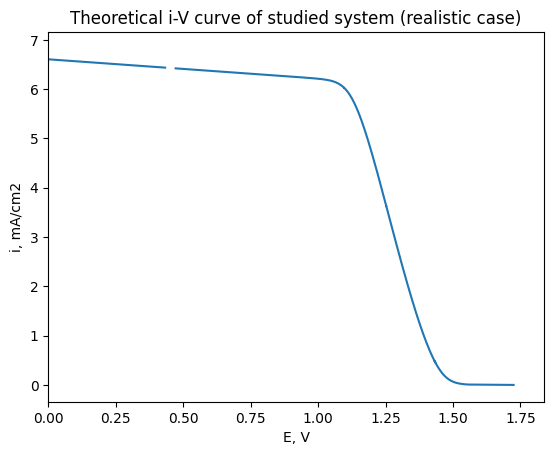

In [15]:
#Calculate efficiency of a custom systemm

#Constants

h=4.135e-15 #Planck constant, eV*s
c=299.8e06 #Speed of light, m/s
q_e=1.602e-19 #Electrin charge, C
kB=8.617e-05 #Boltzman constant, eV/K
RedPlank=6.582e-16 #Reduced Planck constant, eV*s
R=8.314 #Gas constant, J/(K*mol)
F=96485.3321 #Faraday's constant, C/mol
N_A=6.022e23 #Avagadro's number, mol-1

with np.errstate(over='ignore', invalid='ignore'):
    
    #Function to calculate solar absorption efficiency, generated currents and hydrogen production flux
    def solar_absorption(solar_spectra):
        solar_spectra['Incident spectral photon flux m-2*s-1*n-1']=solar_spectra['Global tilt  W*m-2*nm-1']*solar_spectra['Wvlgth nm']*1e-9/h/q_e/c
        solar_spectra['Eg eV']=h*c/solar_spectra['Wvlgth nm']/1e-9
        lamda=np.array(solar_spectra['Wvlgth nm'])
        photon_flux=np.array(solar_spectra['Incident spectral photon flux m-2*s-1*n-1'])
        incident_spectral_photon_flux=np.array(solar_spectra['Incident spectral photon flux m-2*s-1*n-1'])
        absorbed_photon_flux=integrate.cumulative_trapezoid(y=incident_spectral_photon_flux, x=lamda)
        solar_spectra['absorbed_photon_flux, m-2 s-1']=pd.DataFrame(absorbed_photon_flux)
        illuminated_current=q_e*integrate.cumulative_trapezoid(y=photon_flux,x=lamda)
        solar_spectra['Illuminated current A*m-2']=pd.DataFrame(illuminated_current)
        global_tilt=np.array(solar_spectra['Global tilt  W*m-2*nm-1'])
        solar_incident_power=integrate.simpson(y=global_tilt, x=lamda)
        def integrand(E):
            return q_e/4/np.pi**2/RedPlank**3/c**2*E**2/(np.exp(E/kB/T)-1)

        def I(Eg):
            return integrate.quad(integrand, Eg, np.inf)[0]

        vec_explint=np.vectorize(I)

        Eg_AM_15G=np.array(solar_spectra['Eg eV'])
        dark_current=vec_explint(Eg_AM_15G)
        solar_spectra['Dark current A*m-2']=pd.DataFrame(dark_current)

        solar_absorption_efficiency=q_e*AM_15G['absorbed_photon_flux, m-2 s-1']*solar_spectra['Eg eV']/solar_incident_power*100
        solar_spectra['Solar absorption efficiency, %']=pd.DataFrame(solar_absorption_efficiency)
        hydrogen_flux=absorbed_photon_flux/2/N_A #mol m-2 s-1
        hydrogen_flux=hydrogen_flux*1000*3600/10000 #mmol cm-2 h-1
        solar_spectra['hydrogen flux, mmol cm-2 h-1']=pd.DataFrame(hydrogen_flux)

        return solar_spectra, solar_incident_power

    AM_15G, solar_incident_power = solar_absorption(AM_15G)
    Eg_values=np.array(AM_15G['Eg eV'])
    idx = np.abs(Eg - Eg_values).argmin()
    max_hydrogen_flux=AM_15G['hydrogen flux, mmol cm-2 h-1'][idx]

    #Calculate absolute (thermodynamic) efficiency limit
    iL = AM_15G['Illuminated current A*m-2'][idx]
    iD = AM_15G['Dark current A*m-2'][idx]
    j_op_id = iL - iD*(np.exp(U_cell/(kB*T)) - 1)   
    if j_op_id >= iL:
        j_op_id=iL
    if j_op_id < 0:
        j_op_id=0

    SCE_ideal = j_op_id * U_cell / solar_incident_power * 100 #(Equation S13)

    #Realistic case calculations
    from scipy.optimize import brentq
    def V_PEC(j, i, n_e_an, j0_an ):
        iL, iD=f_abs*AM_15G['Illuminated current A*m-2'].iloc[i], AM_15G['Dark current A*m-2'].iloc[i]/ERE
        OCP=n_d*kB*T*np.log((iL-0)/iD+1)
        R_ch=OCP/(iL+iD)
        R_s=r_s*R_ch
        R_sh=r_sh*R_ch

        V_max=R_sh*(iD+iL-j)-j*R_s
        V_min=-1
        
        def f(V):
            return V-kB*T*np.log((iL-j-(V+j*R_s)/R_sh)/iD+1)+j*R_s
        
        f_min = f(V_min)
        f_max = f(V_max)

        if np.isnan(f_min) or np.isnan(f_max) or f_min * f_max > 0:
            return np.nan  
        
        V_PV=brentq(f, V_min, V_max)

        V_an=R*T/alfa/n_e_an/F*np.arcsinh(j/2/j0_an) #Anodic overpotential
        V_cat=R*T/alfa/n_e_cat/F*np.arcsinh(j/2/j0_cat) #Cathodic overpotential

        return V_PV-V_cat-V_an

    vec=np.vectorize(V_PEC)

    def V_PEC_curve(j_array, idx, n_e_an, j0_an):
        #returns i-V curve at a given semiconductor (fixed bangap) for a given reaction (fixed j0_an and n_e)
        return vec(j_array, i=idx, n_e_an=n_e_an, j0_an=j0_an)

    i_lim=iL+iD
    j_grid=j_grid = np.linspace(0, i_lim, 1000)
    iV_curve=V_PEC_curve(j_grid, idx, n_e_an, j0_an)
    idx_current = np.nanargmin(np.abs(iV_curve - U_cell))
    j_op_real=j_grid[idx_current]
    SCE_real=j_op_real*U_cell/solar_incident_power*100
    hydrogen_flux_real=j_op_real/F/2*3600*1000/1000 #mmol/(cm^2 h-1)

    data = [
        ["Total irradiance", solar_incident_power, "W/m²"],
        ["Max theoretical photocurrent density", i_lim/10, "mA/cm²"],
        ["Absolute (thermodynamic) limit of SCE", SCE_ideal, "%"],
        ["Absolute limit of hydrogen prduction rate", max_hydrogen_flux, "mmol cm⁻² h⁻¹"],
        ["Realistic SCE", SCE_real, "%"],
        ["Realistic photocurrent density", j_op_real/10, "mA/cm²"],
        ["Realistic hydrogen production rate", hydrogen_flux_real, "mmol cm⁻² h⁻¹"],
    ]

    print(tabulate(data, headers=["Parameter", "Value", "Unit"], floatfmt=".3f"))

    plt.plot(iV_curve, j_grid/10)
    plt.title('Theoretical i-V curve of studied system (realistic case)')
    plt.xlabel('E, V')
    plt.xlim(left=0)
    plt.ylabel('i, mA/cm2')
    plt.show()

custom_iv_curve = pd.DataFrame({'Voltage, V': iV_curve, 'Photocurrent density, mA/cm2': j_grid/10})
custom_iv_curve.to_excel('iV_curve.xlsx')

